In [1]:
!git clone https://github.com/mjang01011/CS230-Detecting-Transients-in-LSST-Observatory-Data.git
%cd CS230-Detecting-Transients-in-LSST-Observatory-Data

Cloning into 'CS230-Detecting-Transients-in-LSST-Observatory-Data'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 186 (delta 85), reused 158 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (186/186), 39.66 MiB | 14.24 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/content/CS230-Detecting-Transients-in-LSST-Observatory-Data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/zhihanyue/ts2vec.git

import sys
sys.path.append('ts2vec')

Cloning into 'ts2vec'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 133 (delta 23), reused 21 (delta 21), pack-reused 94 (from 1)
Receiving objects: 100% (133/133), 37.01 KiB | 4.63 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from ts2vec import TS2Vec
from lib.dataset import LightCurveDataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


In [5]:
csv_path = '/content/drive/MyDrive/CS230/data/processed_training_global_norm.csv'

dataset = LightCurveDataset(csv_path, max_length=200, use_flux_only=True)

print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Label mapping: {dataset.target_mapping}")
print(f"\nSample data shape: {dataset[0][0].shape}")  # (200, 1)

{np.int64(6): 0, np.int64(15): 1, np.int64(16): 2, np.int64(42): 3, np.int64(52): 4, np.int64(53): 5, np.int64(62): 6, np.int64(64): 7, np.int64(65): 8, np.int64(67): 9, np.int64(88): 10, np.int64(90): 11, np.int64(92): 12, np.int64(95): 13}
Dataset size: 7806
Number of classes: 14
Label mapping: {np.int64(6): 0, np.int64(15): 1, np.int64(16): 2, np.int64(42): 3, np.int64(52): 4, np.int64(53): 5, np.int64(62): 6, np.int64(64): 7, np.int64(65): 8, np.int64(67): 9, np.int64(88): 10, np.int64(90): 11, np.int64(92): 12, np.int64(95): 13}

Sample data shape: torch.Size([200, 1])


## Examine distribution

In [6]:
df = pd.read_csv(csv_path)
object_ids = sorted(df['object_id'].unique())
all_labels = []
for obj_id in object_ids:
    target = df[df['object_id'] == obj_id]['target'].iloc[0]
    all_labels.append(dataset.target_mapping[target])
all_labels = np.array(all_labels)

print(f"Total objects: {len(object_ids)}")
print(f"Label distribution: {np.bincount(all_labels)}")

Total objects: 7806
Label distribution: [ 150  492  919 1184  182   30  482  102  980  208  368 2298  237  174]


important to check: deterministic 80/10/10 split

In [7]:
indices = list(range(len(dataset)))
idx_temp, idx_test = train_test_split(
    indices, test_size=0.1, random_state=SEED, stratify=all_labels)

y_temp = all_labels[idx_temp]
idx_train, idx_val = train_test_split(
    idx_temp, test_size=0.1111, random_state=SEED, stratify=y_temp)

print(f"Train: {len(idx_train)} ({len(idx_train)/len(dataset)*100:.1f}%)")
print(f"Val: {len(idx_val)} ({len(idx_val)/len(dataset)*100:.1f}%)")
print(f"Test: {len(idx_test)} ({len(idx_test)/len(dataset)*100:.1f}%)")

train_subset = Subset(dataset, idx_train)
val_subset = Subset(dataset, idx_val)
test_subset = Subset(dataset, idx_test)

Train: 6244 (80.0%)
Val: 781 (10.0%)
Test: 781 (10.0%)


Get time series data to feed into ts2vec

In [8]:
all_sequences = []
all_labels_ordered = []

for idx in tqdm(range(len(dataset))):
    seq, label = dataset[idx]
    all_sequences.append(seq.numpy())  # (200, 1)
    all_labels_ordered.append(label.item())

data = np.array(all_sequences)  # (n_objects, 200, 1)
print(f"Data shape for TS2Vec: {data.shape}")

Extracting time series data for TS2Vec...


100%|██████████| 7806/7806 [00:00<00:00, 41291.51it/s]


Data shape for TS2Vec: (7806, 200, 1)


Compute ts2vec embeddings

In [ ]:
ts2vec_model_path = '/content/drive/MyDrive/CS230/model_global_norm_5epoch_320reprdim_512batch_001lr_64dim_10depth.pkl'

ts2vec_model = TS2Vec(input_dims=1, device=device, output_dims=320)
ts2vec_model.load(ts2vec_model_path)

X_ts = ts2vec_model.encode(data, encoding_window='full_series', batch_size=256)
print(f"TS2Vec embeddings shape: {X_ts.shape}")

Append metadata

In [10]:
metadata_df = df.groupby('object_id').first()[['ra', 'decl', 'ddf']].reset_index()
metadata_df = metadata_df.sort_values('object_id').reset_index(drop=True)

X_num = metadata_df[['ra', 'decl', 'ddf']].values.astype(np.float32)
X_cat = metadata_df[['ddf']].values.astype(np.int64)

scaler = StandardScaler()
X_num_normalized = scaler.fit_transform(X_num)

print(f"Metadata shape: {metadata_df.shape}")
print(f"Numerical features shape: {X_num_normalized.shape}")
print(f"Categorical features shape: {X_cat.shape}")
print(f"\nNormalized metadata - Mean: {X_num_normalized.mean(axis=0)}")
print(f"Normalized metadata - Std: {X_num_normalized.std(axis=0)}")

Metadata shape: (7806, 4)
Numerical features shape: (7806, 3)
Categorical features shape: (7806, 1)

Normalized metadata - Mean: [-1.0751132e-08  7.8190050e-09 -3.1276020e-08]
Normalized metadata - Std: [1.         1.         0.99999994]


split metadata features

In [11]:
X_ts_train = X_ts[idx_train]
X_ts_val = X_ts[idx_val]
X_ts_test = X_ts[idx_test]
X_num_train = X_num_normalized[idx_train]
X_num_val = X_num_normalized[idx_val]
X_num_test = X_num_normalized[idx_test]
X_cat_train = X_cat[idx_train]
X_cat_val = X_cat[idx_val]
X_cat_test = X_cat[idx_test]

y_train = all_labels[idx_train]
y_val = all_labels[idx_val]
y_test = all_labels[idx_test]

print(f"Train shapes: X_ts={X_ts_train.shape}, X_num={X_num_train.shape}, y={y_train.shape}")
print(f"Val shapes: X_ts={X_ts_val.shape}, X_num={X_num_val.shape}, y={y_val.shape}")
print(f"Test shapes: X_ts={X_ts_test.shape}, X_num={X_num_test.shape}, y={y_test.shape}")

Train shapes: X_ts=(6244, 320), X_num=(6244, 3), y=(6244,)
Val shapes: X_ts=(781, 320), X_num=(781, 3), y=(781,)
Test shapes: X_ts=(781, 320), X_num=(781, 3), y=(781,)


Dataset definition

In [12]:
class FusedDataset(Dataset):
    def __init__(self, X_ts, X_num, X_cat, y):
        self.X_ts = torch.FloatTensor(X_ts)
        self.X_num = torch.FloatTensor(X_num)
        self.X_cat = torch.LongTensor(X_cat)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_ts[idx], self.X_num[idx], self.X_cat[idx], self.y[idx]

train_dataset = FusedDataset(X_ts_train, X_num_train, X_cat_train, y_train)
val_dataset = FusedDataset(X_ts_val, X_num_val, X_cat_val, y_val)
test_dataset = FusedDataset(X_ts_test, X_num_test, X_cat_test, y_test)

Train dataset: 6244
Val dataset: 781
Test dataset: 781


Transformer encoder model (FT)

In [13]:
class FTTransformerClassifier(nn.Module):
    def __init__(self, ts_dim=320, n_num_features=3, cat_cardinalities=[2],
                 d_model=192, n_head=8, n_layers=3, dropout=0.2, n_classes=14):
        super().__init__()

        self.ts_projector = nn.Linear(ts_dim, d_model) # ts2vec dim
        self.num_tokenizers = nn.ModuleList([nn.Linear(1, d_model) for _ in range(n_num_features)]) #metadatas
        self.cat_tokenizers = nn.ModuleList([nn.Embedding(card, d_model) for card in cat_cardinalities])

        # for classification purposes
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # actual encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_head,
            dim_feedforward=int(d_model * 1.33),
            activation="gelu",
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # classifier
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_classes)

    def forward(self, x_ts, x_num, x_cat):
        batch_size = x_ts.shape[0]
        tokens = []
        tokens.append(self.ts_projector(x_ts).unsqueeze(1))

        # numerical tokens
        for i, tokenizer in enumerate(self.num_tokenizers):
            tokens.append(tokenizer(x_num[:, i].unsqueeze(1)).unsqueeze(1))

        # categorical tokens (here, its boolean in our case)
        for i, tokenizer in enumerate(self.cat_tokenizers):
            tokens.append(tokenizer(x_cat[:, i]).unsqueeze(1))

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens] + tokens, dim=1)

        x = self.transformer(x)
        cls_output = x[:, 0]
        cls_output = self.norm(cls_output)
        logits = self.head(cls_output)
        return logits

MLP Class

In [ ]:
class FusedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

training logic

In [14]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x_ts, x_num, x_cat, y in dataloader:
        x_ts, x_num, x_cat, y = x_ts.to(device), x_num.to(device), x_cat.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x_ts, x_num, x_cat)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_ts, x_num, x_cat, y in dataloader:
            x_ts, x_num, x_cat, y = x_ts.to(device), x_num.to(device), x_cat.to(device), y.to(device)
            outputs = model(x_ts, x_num, x_cat)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(dataloader), acc, f1, all_preds, all_labels

grid search parameters

In [15]:
param_grid = {
    'd_model': [128, 192, 256],
    'n_head': [4, 8],
    'n_layers': [2, 3, 4],
    'dropout': [0.2, 0.3],
    'lr': [1e-4, 5e-4],
    'weight_decay': [1e-5, 1e-4]
}
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
n_classes = dataset.num_classes

Total combinations: 144
Number of classes: 14

Grid:
  d_model: [128, 192, 256]
  n_head: [4, 8]
  n_layers: [2, 3, 4]
  dropout: [0.2, 0.3]
  lr: [0.0001, 0.0005]
  weight_decay: [1e-05, 0.0001]


Trainer with grid search

In [16]:
def train_with_params(d_model, n_head, n_layers, dropout, lr, weight_decay, num_epochs=50, batch_size=128):
    model = FTTransformerClassifier(
        ts_dim=X_ts.shape[1],
        n_num_features=3,
        cat_cardinalities=[2],
        d_model=d_model,
        n_head=n_head,
        n_layers=n_layers,
        dropout=dropout,
        n_classes=n_classes
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    best_model_state = None
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, _, _ = validate(model, val_loader, criterion, device)
        scheduler.step()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

    return best_model_state, best_val_loss, train_losses, val_losses

results = []
config_idx = 0

for d_model in param_grid['d_model']:
    for n_head in param_grid['n_head']:
        for n_layers in param_grid['n_layers']:
            for dropout in param_grid['dropout']:
                for lr in param_grid['lr']:
                    for weight_decay in param_grid['weight_decay']:
                        config_idx += 1
                        print(f"\n[{config_idx}/{total_combinations}] d_model={d_model}, n_head={n_head}, n_layers={n_layers}, dropout={dropout}, lr={lr}, wd={weight_decay}")

                        model_state, val_loss, train_losses, val_losses = train_with_params(
                            d_model, n_head, n_layers, dropout, lr, weight_decay
                        )

                        results.append({
                            'd_model': d_model,
                            'n_head': n_head,
                            'n_layers': n_layers,
                            'dropout': dropout,
                            'lr': lr,
                            'weight_decay': weight_decay,
                            'val_loss': val_loss,
                            'model_state': model_state,
                            'train_losses': train_losses,
                            'val_losses': val_losses
                        })
                        print(f"Best Val Loss: {val_loss:.4f}")

results.sort(key=lambda x: x['val_loss'])
best_config = results[0]

print("\n" + "="*80)
print("Best Configuration:")
print(f"d_model={best_config['d_model']}, n_head={best_config['n_head']}, n_layers={best_config['n_layers']}, dropout={best_config['dropout']}")
print(f"lr={best_config['lr']}, weight_decay={best_config['weight_decay']}")
print(f"Best Val Loss: {best_config['val_loss']:.4f}")
print("="*80)


[1/144] d_model=128, n_head=4, n_layers=2, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2599

[2/144] d_model=128, n_head=4, n_layers=2, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2590

[3/144] d_model=128, n_head=4, n_layers=2, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2175

[4/144] d_model=128, n_head=4, n_layers=2, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2130

[5/144] d_model=128, n_head=4, n_layers=2, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2777

[6/144] d_model=128, n_head=4, n_layers=2, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2769

[7/144] d_model=128, n_head=4, n_layers=2, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2365

[8/144] d_model=128, n_head=4, n_layers=2, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2328

[9/144] d_model=128, n_head=4, n_layers=3, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2767

[10/144] d_model=128, n_head=4, n_layers=3, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2656

[11/144] d_model=128, n_head=4, n_layers=3, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2190

[12/144] d_model=128, n_head=4, n_layers=3, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2104

[13/144] d_model=128, n_head=4, n_layers=3, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2625

[14/144] d_model=128, n_head=4, n_layers=3, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2761

[15/144] d_model=128, n_head=4, n_layers=3, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2267

[16/144] d_model=128, n_head=4, n_layers=3, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2329

[17/144] d_model=128, n_head=4, n_layers=4, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2425

[18/144] d_model=128, n_head=4, n_layers=4, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2622

[19/144] d_model=128, n_head=4, n_layers=4, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2269

[20/144] d_model=128, n_head=4, n_layers=4, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2364

[21/144] d_model=128, n_head=4, n_layers=4, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2640

[22/144] d_model=128, n_head=4, n_layers=4, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2696

[23/144] d_model=128, n_head=4, n_layers=4, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2258

[24/144] d_model=128, n_head=4, n_layers=4, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2236

[25/144] d_model=128, n_head=8, n_layers=2, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2749

[26/144] d_model=128, n_head=8, n_layers=2, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2683

[27/144] d_model=128, n_head=8, n_layers=2, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2087

[28/144] d_model=128, n_head=8, n_layers=2, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2183

[29/144] d_model=128, n_head=8, n_layers=2, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2857

[30/144] d_model=128, n_head=8, n_layers=2, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2904

[31/144] d_model=128, n_head=8, n_layers=2, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2251

[32/144] d_model=128, n_head=8, n_layers=2, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2372

[33/144] d_model=128, n_head=8, n_layers=3, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2624

[34/144] d_model=128, n_head=8, n_layers=3, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2760

[35/144] d_model=128, n_head=8, n_layers=3, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2122

[36/144] d_model=128, n_head=8, n_layers=3, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2246

[37/144] d_model=128, n_head=8, n_layers=3, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2682

[38/144] d_model=128, n_head=8, n_layers=3, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2814

[39/144] d_model=128, n_head=8, n_layers=3, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2179

[40/144] d_model=128, n_head=8, n_layers=3, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2198

[41/144] d_model=128, n_head=8, n_layers=4, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2641

[42/144] d_model=128, n_head=8, n_layers=4, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2493

[43/144] d_model=128, n_head=8, n_layers=4, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2019

[44/144] d_model=128, n_head=8, n_layers=4, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2093

[45/144] d_model=128, n_head=8, n_layers=4, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2702

[46/144] d_model=128, n_head=8, n_layers=4, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2805

[47/144] d_model=128, n_head=8, n_layers=4, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2199

[48/144] d_model=128, n_head=8, n_layers=4, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2230

[49/144] d_model=192, n_head=4, n_layers=2, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2338

[50/144] d_model=192, n_head=4, n_layers=2, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2247

[51/144] d_model=192, n_head=4, n_layers=2, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2126

[52/144] d_model=192, n_head=4, n_layers=2, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2146

[53/144] d_model=192, n_head=4, n_layers=2, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2515

[54/144] d_model=192, n_head=4, n_layers=2, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2442

[55/144] d_model=192, n_head=4, n_layers=2, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2156

[56/144] d_model=192, n_head=4, n_layers=2, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2336

[57/144] d_model=192, n_head=4, n_layers=3, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2426

[58/144] d_model=192, n_head=4, n_layers=3, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2178

[59/144] d_model=192, n_head=4, n_layers=3, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2075

[60/144] d_model=192, n_head=4, n_layers=3, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2144

[61/144] d_model=192, n_head=4, n_layers=3, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2483

[62/144] d_model=192, n_head=4, n_layers=3, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2348

[63/144] d_model=192, n_head=4, n_layers=3, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2000

[64/144] d_model=192, n_head=4, n_layers=3, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2121

[65/144] d_model=192, n_head=4, n_layers=4, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2016

[66/144] d_model=192, n_head=4, n_layers=4, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2067

[67/144] d_model=192, n_head=4, n_layers=4, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2239

[68/144] d_model=192, n_head=4, n_layers=4, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2034

[69/144] d_model=192, n_head=4, n_layers=4, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2388

[70/144] d_model=192, n_head=4, n_layers=4, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2534

[71/144] d_model=192, n_head=4, n_layers=4, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2237

[72/144] d_model=192, n_head=4, n_layers=4, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2076

[73/144] d_model=192, n_head=8, n_layers=2, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2482

[74/144] d_model=192, n_head=8, n_layers=2, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2234

[75/144] d_model=192, n_head=8, n_layers=2, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2107

[76/144] d_model=192, n_head=8, n_layers=2, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2168

[77/144] d_model=192, n_head=8, n_layers=2, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2351

[78/144] d_model=192, n_head=8, n_layers=2, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2499

[79/144] d_model=192, n_head=8, n_layers=2, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2257

[80/144] d_model=192, n_head=8, n_layers=2, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2005

[81/144] d_model=192, n_head=8, n_layers=3, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2385

[82/144] d_model=192, n_head=8, n_layers=3, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2233

[83/144] d_model=192, n_head=8, n_layers=3, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2287

[84/144] d_model=192, n_head=8, n_layers=3, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2047

[85/144] d_model=192, n_head=8, n_layers=3, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2529

[86/144] d_model=192, n_head=8, n_layers=3, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2410

[87/144] d_model=192, n_head=8, n_layers=3, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2070

[88/144] d_model=192, n_head=8, n_layers=3, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2200

[89/144] d_model=192, n_head=8, n_layers=4, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2300

[90/144] d_model=192, n_head=8, n_layers=4, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2271

[91/144] d_model=192, n_head=8, n_layers=4, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2101

[92/144] d_model=192, n_head=8, n_layers=4, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1903

[93/144] d_model=192, n_head=8, n_layers=4, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2409

[94/144] d_model=192, n_head=8, n_layers=4, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2295

[95/144] d_model=192, n_head=8, n_layers=4, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2154

[96/144] d_model=192, n_head=8, n_layers=4, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1908

[97/144] d_model=256, n_head=4, n_layers=2, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2286

[98/144] d_model=256, n_head=4, n_layers=2, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2128

[99/144] d_model=256, n_head=4, n_layers=2, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1851

[100/144] d_model=256, n_head=4, n_layers=2, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1955

[101/144] d_model=256, n_head=4, n_layers=2, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2297

[102/144] d_model=256, n_head=4, n_layers=2, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2321

[103/144] d_model=256, n_head=4, n_layers=2, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2030

[104/144] d_model=256, n_head=4, n_layers=2, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1920

[105/144] d_model=256, n_head=4, n_layers=3, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2140

[106/144] d_model=256, n_head=4, n_layers=3, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2103

[107/144] d_model=256, n_head=4, n_layers=3, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1966

[108/144] d_model=256, n_head=4, n_layers=3, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2002

[109/144] d_model=256, n_head=4, n_layers=3, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2084

[110/144] d_model=256, n_head=4, n_layers=3, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2097

[111/144] d_model=256, n_head=4, n_layers=3, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2130

[112/144] d_model=256, n_head=4, n_layers=3, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1900

[113/144] d_model=256, n_head=4, n_layers=4, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2090

[114/144] d_model=256, n_head=4, n_layers=4, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1986

[115/144] d_model=256, n_head=4, n_layers=4, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2201

[116/144] d_model=256, n_head=4, n_layers=4, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1966

[117/144] d_model=256, n_head=4, n_layers=4, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2172

[118/144] d_model=256, n_head=4, n_layers=4, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2135

[119/144] d_model=256, n_head=4, n_layers=4, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2071

[120/144] d_model=256, n_head=4, n_layers=4, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1847

[121/144] d_model=256, n_head=8, n_layers=2, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1997

[122/144] d_model=256, n_head=8, n_layers=2, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1954

[123/144] d_model=256, n_head=8, n_layers=2, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2122

[124/144] d_model=256, n_head=8, n_layers=2, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1943

[125/144] d_model=256, n_head=8, n_layers=2, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2216

[126/144] d_model=256, n_head=8, n_layers=2, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2337

[127/144] d_model=256, n_head=8, n_layers=2, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2209

[128/144] d_model=256, n_head=8, n_layers=2, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2203

[129/144] d_model=256, n_head=8, n_layers=3, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2168

[130/144] d_model=256, n_head=8, n_layers=3, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2214

[131/144] d_model=256, n_head=8, n_layers=3, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2132

[132/144] d_model=256, n_head=8, n_layers=3, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2215

[133/144] d_model=256, n_head=8, n_layers=3, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2235

[134/144] d_model=256, n_head=8, n_layers=3, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2182

[135/144] d_model=256, n_head=8, n_layers=3, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1981

[136/144] d_model=256, n_head=8, n_layers=3, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2034

[137/144] d_model=256, n_head=8, n_layers=4, dropout=0.2, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1998

[138/144] d_model=256, n_head=8, n_layers=4, dropout=0.2, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1863

[139/144] d_model=256, n_head=8, n_layers=4, dropout=0.2, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2037

[140/144] d_model=256, n_head=8, n_layers=4, dropout=0.2, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2114

[141/144] d_model=256, n_head=8, n_layers=4, dropout=0.3, lr=0.0001, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2320

[142/144] d_model=256, n_head=8, n_layers=4, dropout=0.3, lr=0.0001, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2158

[143/144] d_model=256, n_head=8, n_layers=4, dropout=0.3, lr=0.0005, wd=1e-05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.1979

[144/144] d_model=256, n_head=8, n_layers=4, dropout=0.3, lr=0.0005, wd=0.0001


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Best Val Loss: 1.2039

Best Configuration:
d_model=256, n_head=4, n_layers=4, dropout=0.3
lr=0.0005, weight_decay=0.0001
Best Val Loss: 1.1847


Evaluation: load in best model from previous block and test on test Set

In [17]:
best_model = FTTransformerClassifier(
    ts_dim=X_ts.shape[1],
    n_num_features=3,
    cat_cardinalities=[2],
    d_model=best_config['d_model'],
    n_head=best_config['n_head'],
    n_layers=best_config['n_layers'],
    dropout=best_config['dropout'],
    n_classes=n_classes
).to(device)

best_model.load_state_dict(best_config['model_state'])
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.CrossEntropyLoss()

test_loss, test_acc, test_f1, test_preds, test_labels = validate(best_model, test_loader, criterion, device)

print("\nTest Set Performance:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1: {test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds,
                          target_names=[f"Class {dataset.ordered_labels[i]}" for i in range(n_classes)]))


Test Set Performance:
Test Loss: 1.1970
Test Accuracy: 0.5839
Test Macro F1: 0.4162

Classification Report:
              precision    recall  f1-score   support

     Class 6       0.43      0.40      0.41        15
    Class 15       0.25      0.14      0.18        49
    Class 16       0.91      0.85      0.88        92
    Class 42       0.56      0.29      0.39       119
    Class 52       0.00      0.00      0.00        18
    Class 53       0.67      0.67      0.67         3
    Class 62       0.00      0.00      0.00        48
    Class 64       0.25      0.10      0.14        10
    Class 65       0.68      0.77      0.72        98
    Class 67       0.00      0.00      0.00        21
    Class 88       0.78      0.78      0.78        37
    Class 90       0.50      0.87      0.64       230
    Class 92       0.91      0.83      0.87        24
    Class 95       0.20      0.12      0.15        17

    accuracy                           0.58       781
   macro avg       0.44  

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Plot loss curve

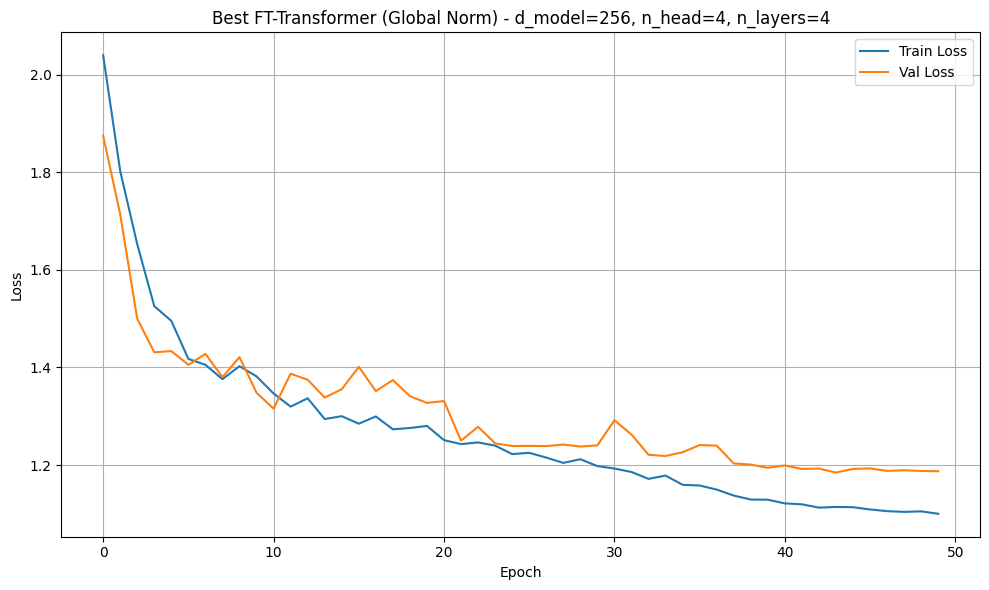

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(best_config['train_losses'], label='Train Loss')
ax.plot(best_config['val_losses'], label='Val Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Best FT-Transformer (Global Norm) - d_model={best_config["d_model"]}, n_head={best_config["n_head"]}, n_layers={best_config["n_layers"]}')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

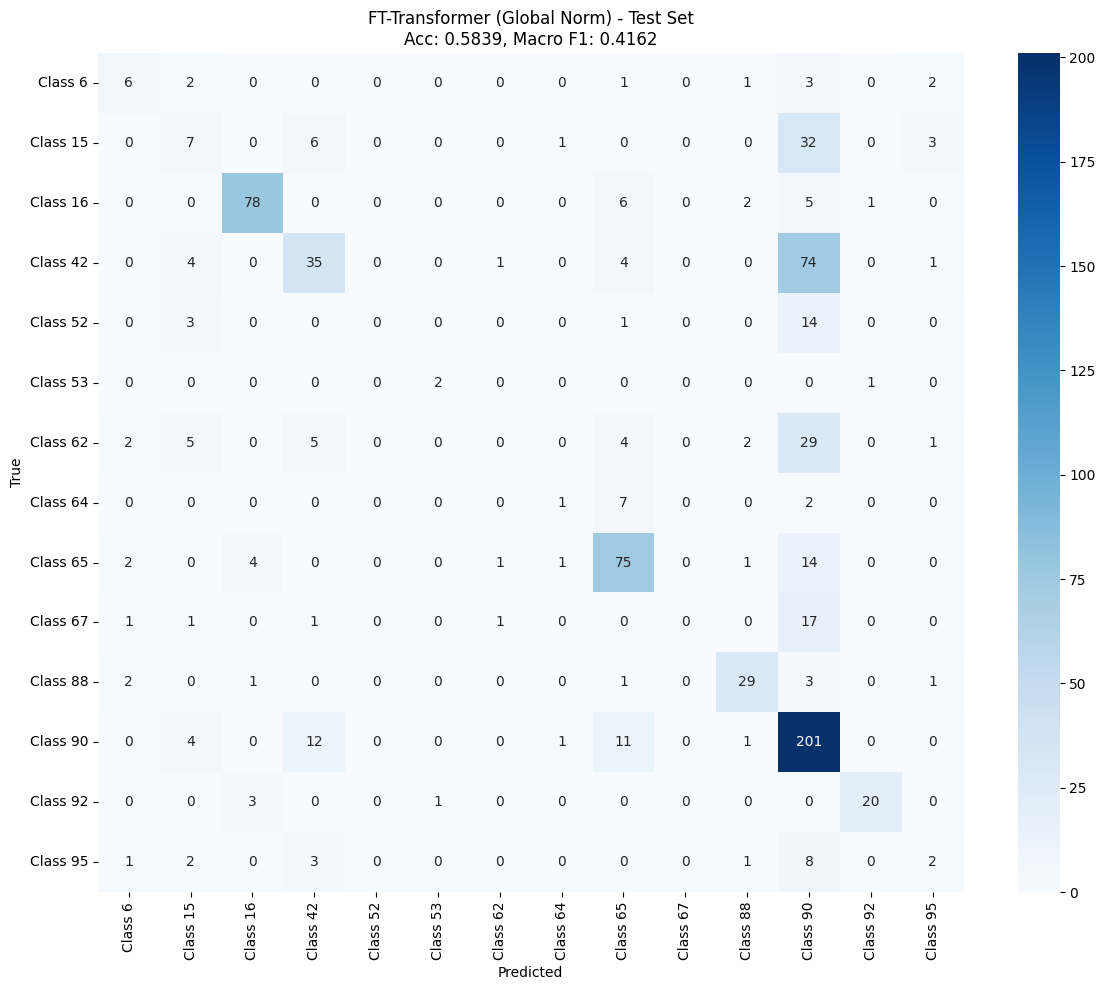

In [19]:
cm_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {dataset.ordered_labels[i]}" for i in range(n_classes)],
            yticklabels=[f"Class {dataset.ordered_labels[i]}" for i in range(n_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'FT-Transformer (Global Norm) - Test Set\nAcc: {test_acc:.4f}, Macro F1: {test_f1:.4f}')
plt.tight_layout()
plt.show()